# Training iterations

**Goal:** Try increasing the number of training iterations, and check if this _helps_ for the examples that I have that weren't doing so good.

**Plan:** Use the model with $H=Q=16$, with $\sqrt{D}$ softmax temperature.

In [37]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# IO pkgs
import yaml, json
from glob import glob

# custom code
import os
os.sys.path.append('code')
from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SlotAttentionPosEmbed

In [5]:
device='cuda:1'

In [7]:
model_i = 25900

In [11]:
# Open up the configs file to retreive the parameters
config = 'code/configs/2rings-sqrtD.yaml'

with open(config, "r")as cfile:
    cdict = yaml.safe_load(cfile)

opt = cdict["opt"]
hps = cdict["hps"]
kwargs = cdict["data"] # to pass to the data loading fct

In [12]:
# Define the architecture 
hps['device'] = device # the model also needs to 
model = SlotAttentionPosEmbed(**hps).to(device)

In [17]:
# Load in the weights 
print(f'Starting from an earlier training')

# Check for what was the last training iteration
modelChkpts = glob(f'code/models/2rings-sqrtD/m_*.pt')
if len(modelChkpts) == 0:
    print('ERROR -- No files fround for',modelChkpts, 'when requesting to train from warm_start')
    raise FileNotFoundError

savedIters = [mName.split('/')[-1].split('.')[0].split('_')[-1] for mName in modelChkpts   ]
savedIters = np.array([int(i) for i in savedIters])                     
lastIter = np.max(savedIters)

modelToLoad = f'code/models/2rings-sqrtD/m_{lastIter}.pt'

Starting from an earlier training


In [18]:
model.load_state_dict(torch.load(modelToLoad))
model.to(device)

SlotAttentionPosEmbed(
  (dataN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (queryN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (toK): Linear(in_features=16, out_features=16, bias=True)
  (toV): Linear(in_features=16, out_features=16, bias=True)
  (gru): GRUCell(16, 16)
  (CNN_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (posEnc): SoftPositionalEmbed(
    (dense): Linear(in_features=4, out_features=16, bias=True)
  )
  (init_mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
)

**Generate a "test set"**

In [25]:
bs = 10

X, Y, mask = make_batch(N_events=bs, device=device, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


**Step 0:** For each of these 10 examples, just look at the reco over the training iterations.

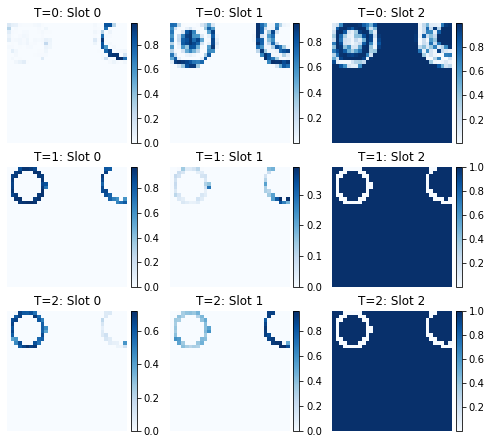

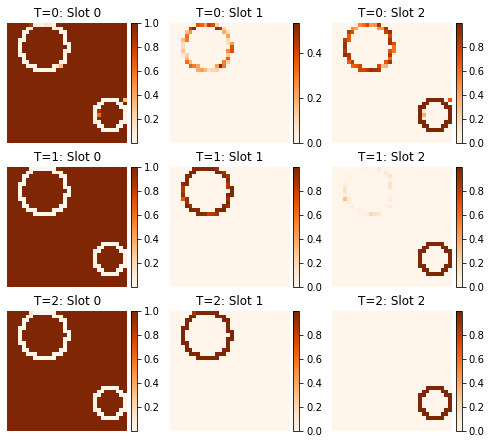

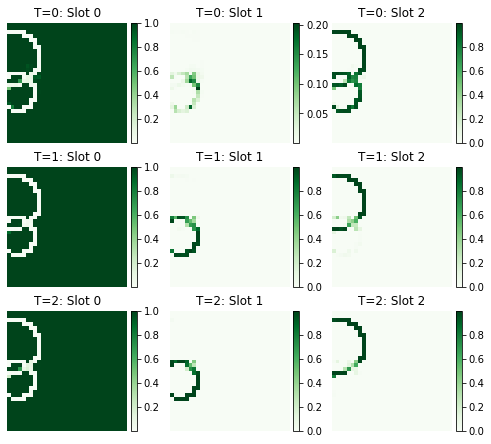

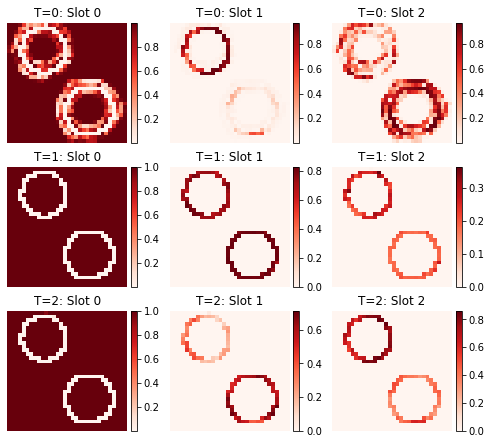

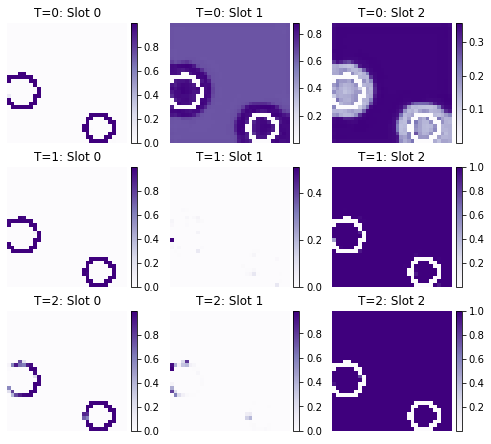

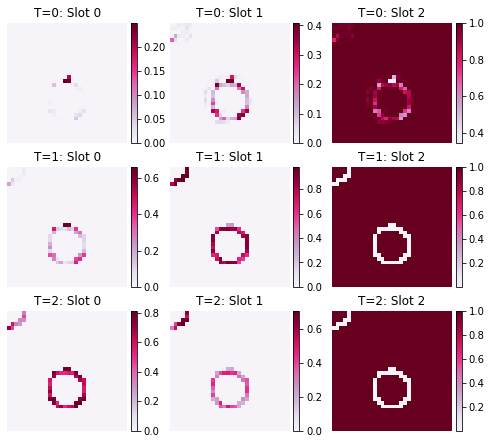

In [41]:
model.n_iter = 2

for iEvt,cmap in enumerate(['Blues','Oranges','Greens','Reds','Purples','PuRd']):

    plot_kslots_iters(model, X, iEvt=iEvt, cmap=cmap, 
                      # figname=f'{figDir}/slots-unroll-iter{i}-evt{iEvt}.jpg',
                      showImg=True)


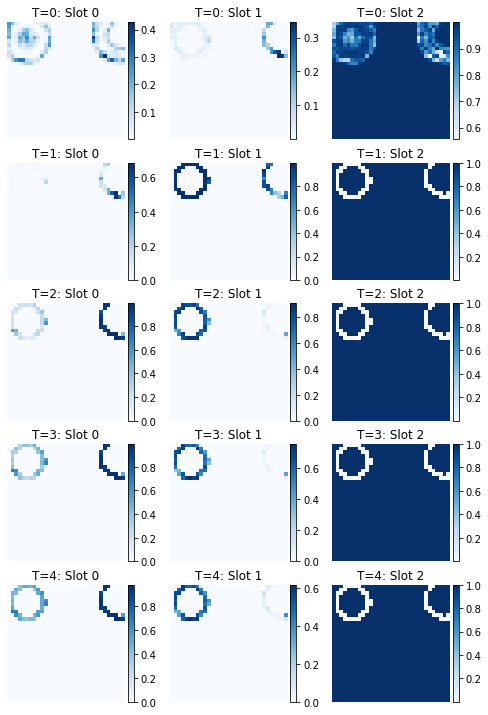

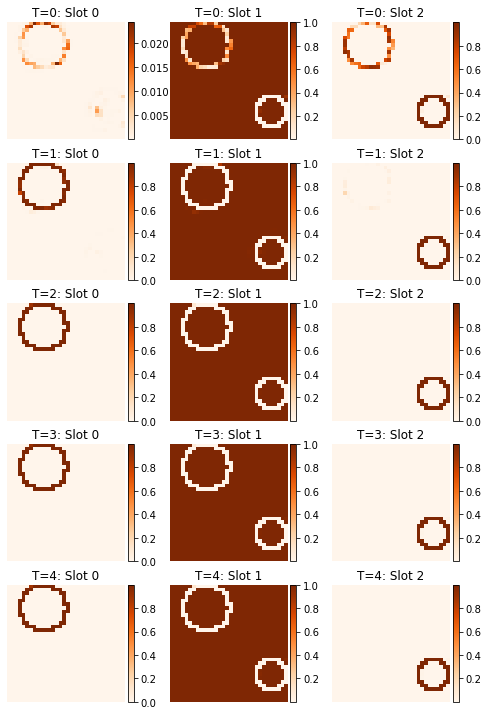

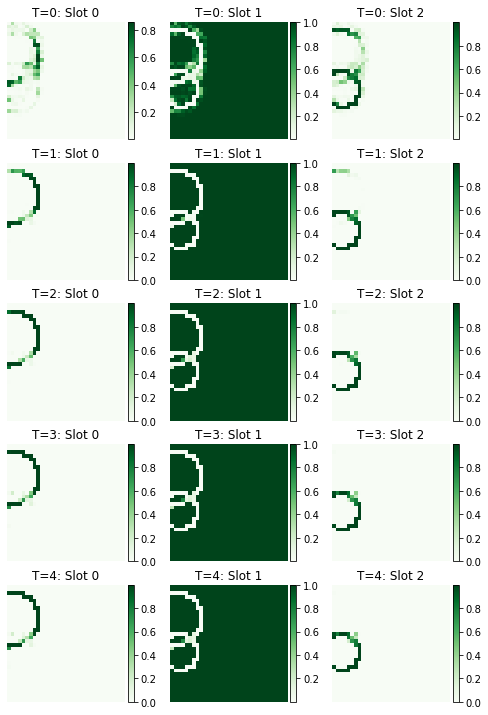

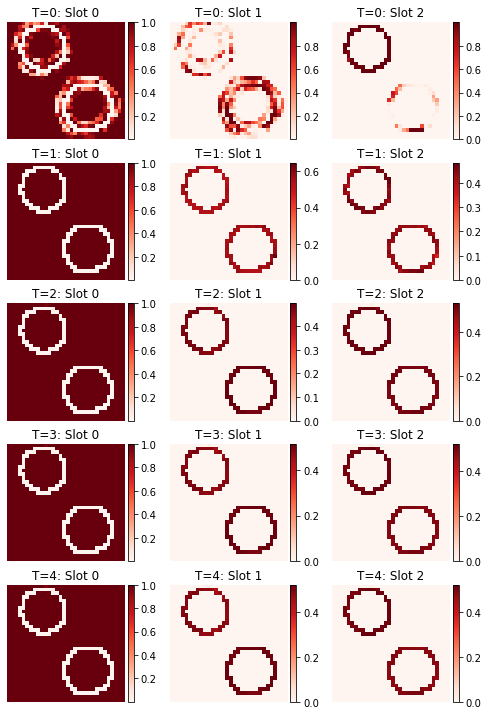

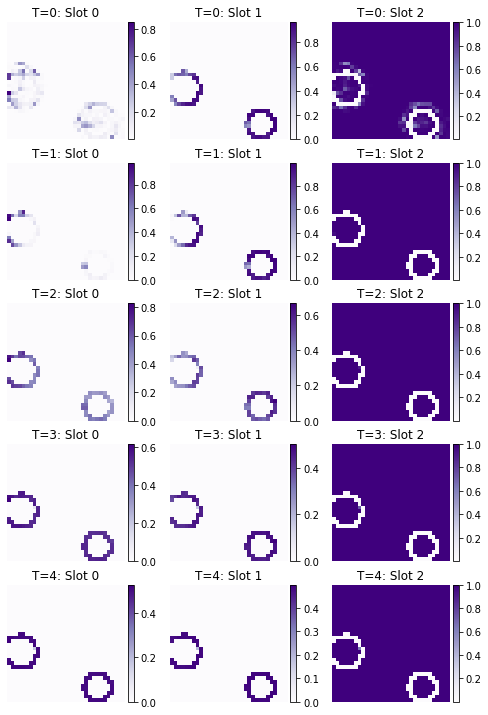

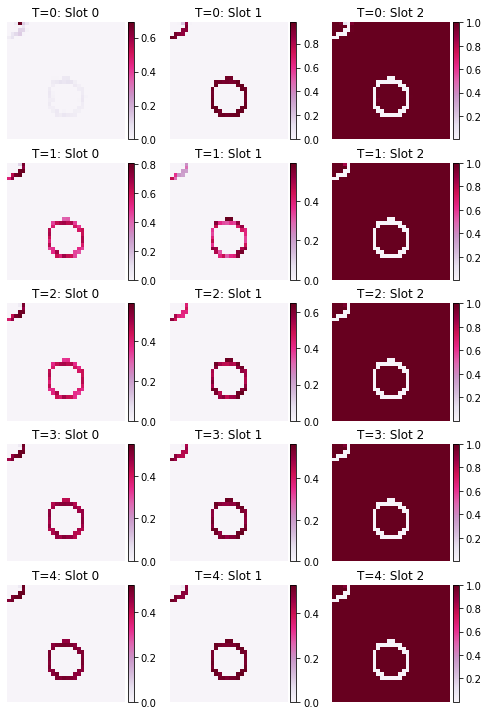

In [42]:
model.n_iter = 4

for iEvt,cmap in enumerate(['Blues','Oranges','Greens','Reds','Purples','PuRd']):

    plot_kslots_iters(model, X, iEvt=iEvt, cmap=cmap, 
                      # figname=f'{figDir}/slots-unroll-iter{i}-evt{iEvt}.jpg',
                      showImg=True)


OK, for only 2 rings just increasing the number of evalution steps wasn't helping... but maybe it would help for the trianing steps?

code/models/2rings-T2/loss.json
12001
code/models/2rings-T3/loss.json
11001
code/models/2rings-T4/loss.json
11001
code/models/2rings-T5/loss.json
11001


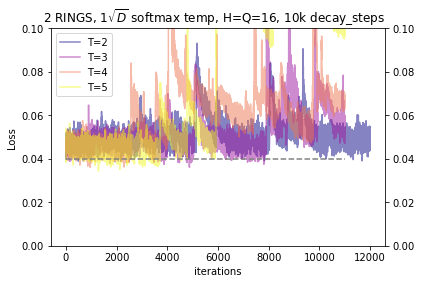

In [68]:
alpha=.5

import matplotlib as mlp
try:
    cmap = mlp.colormaps.get_cmap('plasma')
except:
    cmap =mlp.colorbar.cm.plasma

for T,i in zip([2,3,4,5],np.linspace(0,1,4)):
    
    color = cmap(i)
    fname = f'code/models/2rings-T{T}/loss.json'
    print(fname)
    try:
        with open(fname) as f:
            ld = json.load(f)
        print(len(ld))
        plt.plot(ld,label=f'T={T}',alpha=alpha,color=color)

    except FileNotFoundError:
        print(f'^ this file doesn\'t exist yet')

plt.tick_params(axis='y', which='both', labelleft=True, labelright=True,
                left=True, right=True)

plt.plot([0,len(ld)],[.04]*2,ls='--',color='grey')

plt.title('2 RINGS, $1\sqrt{D}$ softmax temp, H=Q=16, 10k decay_steps',loc='right')
plt.xlabel('iterations')
plt.ylabel('Loss')
# plt.xlim(0,len(ld))
plt.ylim(0,.1)
plt.legend()

plt.show()

**Look at the predictions for the model trained with T=3**

In [63]:
# Check for what was the last training iteration
modelChkpts = glob(f'code/models/2rings-T3/m_*.pt')
if len(modelChkpts) == 0:
    print('ERROR -- No files fround for',modelChkpts, 'when requesting to train from warm_start')
    raise FileNotFoundError

savedIters = [mName.split('/')[-1].split('.')[0].split('_')[-1] for mName in modelChkpts   ]
savedIters = np.array([int(i) for i in savedIters])                     
lastIter = np.max(savedIters)

modelPath = f'code/models/2rings-T3/m_{lastIter}.pt'

In [60]:
hps['device'] = device # the model also needs to 
hps['n_iter'] = 3
m_T3 = SlotAttentionPosEmbed(**hps).to(device)

In [64]:
m_T3.load_state_dict(torch.load(modelPath))
m_T3.to(device)

SlotAttentionPosEmbed(
  (dataN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (queryN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (toK): Linear(in_features=16, out_features=16, bias=True)
  (toV): Linear(in_features=16, out_features=16, bias=True)
  (gru): GRUCell(16, 16)
  (CNN_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (posEnc): SoftPositionalEmbed(
    (dense): Linear(in_features=4, out_features=16, bias=True)
  )
  (init_mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
)

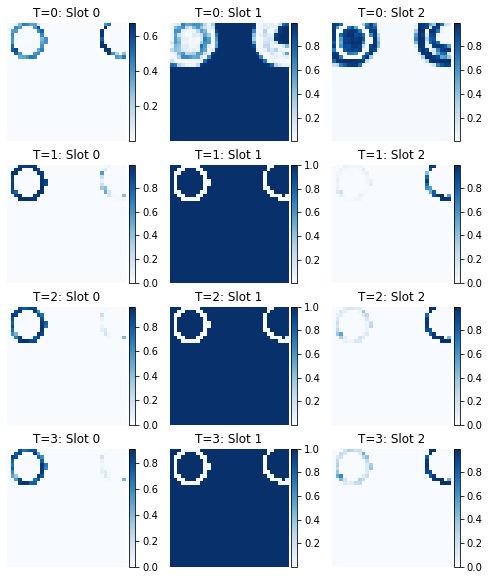

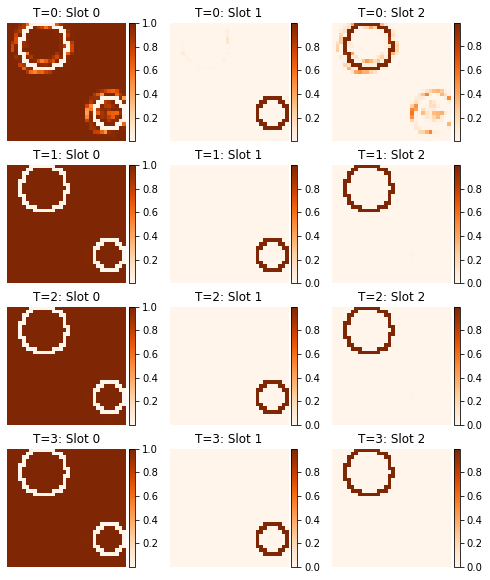

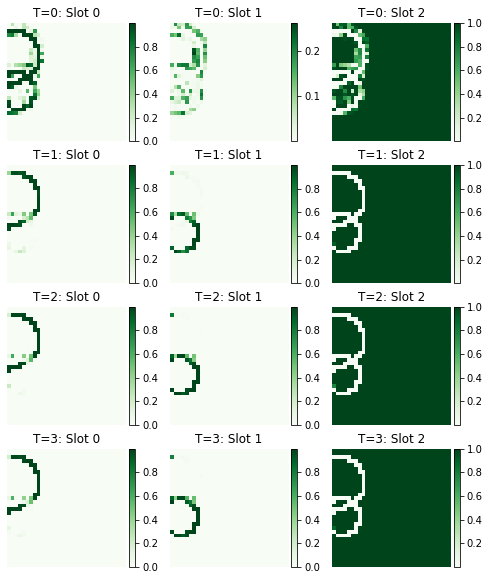

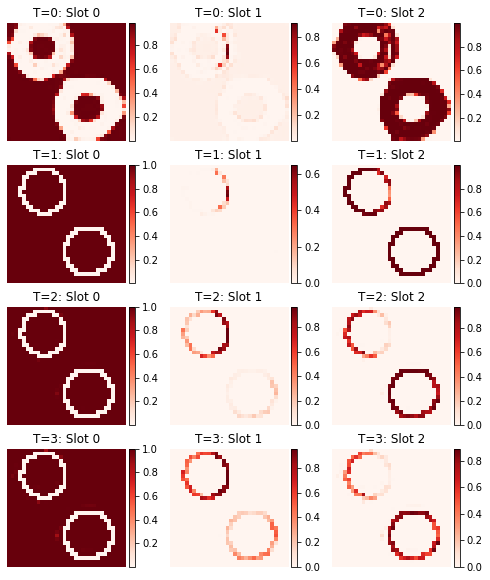

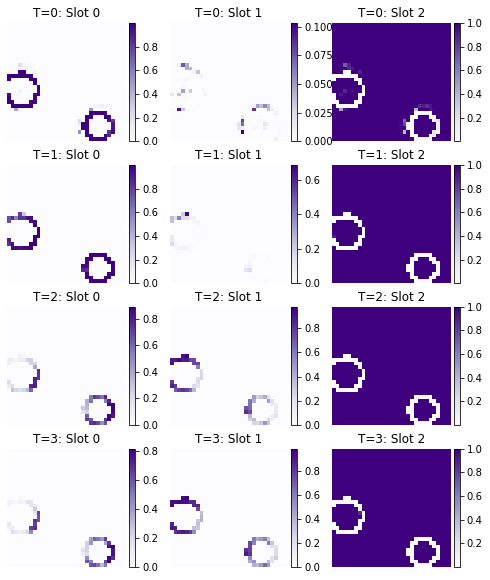

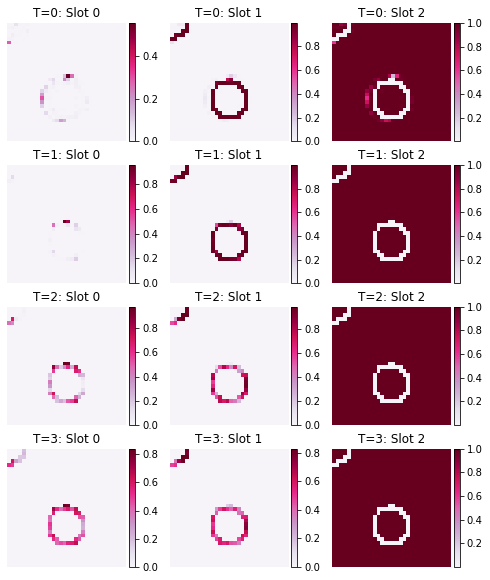

In [65]:
for iEvt,cmap in enumerate(['Blues','Oranges','Greens','Reds','Purples','PuRd']):

    plot_kslots_iters(m_T3, X, iEvt=iEvt, cmap=cmap, 
                      # figname=f'{figDir}/slots-unroll-iter{i}-evt{iEvt}.jpg',
                      showImg=True)
